In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/LIVEcell_assignment

/content/drive/.shortcut-targets-by-id/1_iywNEpG4MhscmFlETPnjUVmhKxeee8B/LIVEcell_assignment


In [3]:
# Define directories for train, val, and test datasets
image_directories = {
    "train": "/content/drive/MyDrive/LIVEcell_assignment/train/",
    "val": "/content/drive/MyDrive/LIVEcell_assignment/val/",
    "test": "/content/drive/MyDrive/LIVEcell_assignment/test/"
}

mask_directories = {
    "train": "/content/drive/MyDrive/LIVEcell_assignment/train/masks/",
    "val": "/content/drive/MyDrive/LIVEcell_assignment/val/masks/",
    "test": "/content/drive/MyDrive/LIVEcell_assignment/test/masks/"
}

SIZE = 256

# Finding global mean and std for normalization


To ensure consistency in pixel intensity across input images, we applied normalization by centering pixel values around zero. Specifically, we computed the mean and standard deviation of pixel intensity values across the entire dataset. Each pixel intensity was then adjusted by subtracting the calculated mean and dividing by the standard deviation.


 
This approach is inspired by the normalization method used in the [LIVECell—A large-scale dataset for label-free live cell segmentation paper](https://www.nature.com/articles/s41592-021-01249-6), where a global mean and standard deviation of 128 and 11.58, respectively, were used. By recalculating these values for our specific dataset, we ensure a normalization scheme that is tailored to the data distribution, potentially enhancing model performance on our specific task.


Global Mean: 128.02333355732696
Global Standard Deviation: 7.079153483606509


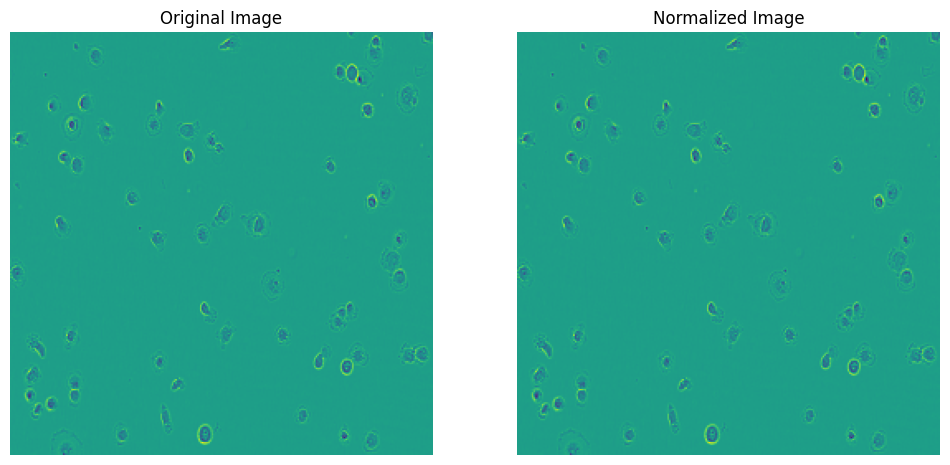

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

SIZE = 256

def calculate_global_mean_std(image_directories, size=SIZE):
    pixel_values = []

    for key, image_dir in image_directories.items():
        image_names = sorted(os.listdir(image_dir))

        for image_name in image_names:
            if image_name.endswith('.tif'):
                image_path = os.path.join(image_dir, image_name)
                image = Image.open(image_path).resize((size, size))
                image_array = np.array(image)
                pixel_values.append(image_array)

    pixel_values = np.array(pixel_values)

    # Calculate global mean and std across the entire dataset
    mean = np.mean(pixel_values, axis=(0, 1, 2))  # Mean across height, width, and batch
    std = np.std(pixel_values, axis=(0, 1, 2))    # Std across height, width, and batch

    return mean, std


# Function to normalize an image
def normalize_image(image, mean, std):
    return (image - mean) / std

# Function to visualize an image before and after normalization
def visualize_image_normalization(image_path, mean, std, size=SIZE):
    image = Image.open(image_path).resize((size, size))
    original_image = np.array(image)

    # Normalize the image
    normalized_image = normalize_image(original_image, mean, std)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Normalized Image")
    plt.imshow(normalized_image)
    plt.axis('off')

    plt.show()



# Calculate global mean and standard deviation for all datasets
global_mean, global_std = calculate_global_mean_std(image_directories)
print("Global Mean:", global_mean)
print("Global Standard Deviation:", global_std)


image_example_path = os.path.join(image_directories["train"], sorted(os.listdir(image_directories["train"]))[0])  # First image in train directory
visualize_image_normalization(image_example_path, global_mean, global_std)


So values for global mean and std which I found:


Global Mean: 128.02333355732696

Global Standard Deviation: 7.079153483606509


# Data preprocessing. Defining data generator.


In [ ]:
import os
from PIL import Image
import numpy as np

# Model config
config = {
    'batch_size': 16,
    'epochs': 20
}

# Global mean and standard deviation for normalization
GLOBAL_MEAN = 128.02333355732696
GLOBAL_STD =  7.079153483606509

# Set steps per epoch and validation steps
config['steps_per_epoch'] = len([f for f in os.listdir(image_directories["train"]) if f.endswith('.tif')]) // config['batch_size']
config['validation_steps'] = len([f for f in os.listdir(image_directories["val"]) if f.endswith('.tif')]) // config['batch_size']

def normalize_images(batch_images, mean=GLOBAL_MEAN, std=GLOBAL_STD):
    return (batch_images - mean) / std

def data_generator(image_dir, mask_dir, batch_size, size=SIZE):
    image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    mask_names = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])

    while True:
        for i in range(0, len(image_names), batch_size):
            batch_images = []
            batch_masks = []
            for j in range(i, min(i + batch_size, len(image_names))):
                image_path = os.path.join(image_dir, image_names[j])
                mask_path = os.path.join(mask_dir, mask_names[j])

                
                image = Image.open(image_path).resize((size, size))

                # Load and resize the mask, and convert to binary
                mask = Image.open(mask_path).resize((size, size))
                mask = np.array(mask)
                mask = np.where(mask > 0, 1, 0)  # Convert mask to binary: 1 for cells, 0 for background

                batch_images.append(image)
                batch_masks.append(mask)

            # Convert lists to arrays
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Normalize the batch of images
            batch_images = normalize_images(batch_images)

            yield batch_images, np.expand_dims(batch_masks, -1)


train_generator = data_generator(image_directories["train"], mask_directories["train"], batch_size=config['batch_size'])
val_generator = data_generator(image_directories["val"], mask_directories["val"], batch_size=config['batch_size'])


Ensure that masks and images was loaded correctly.

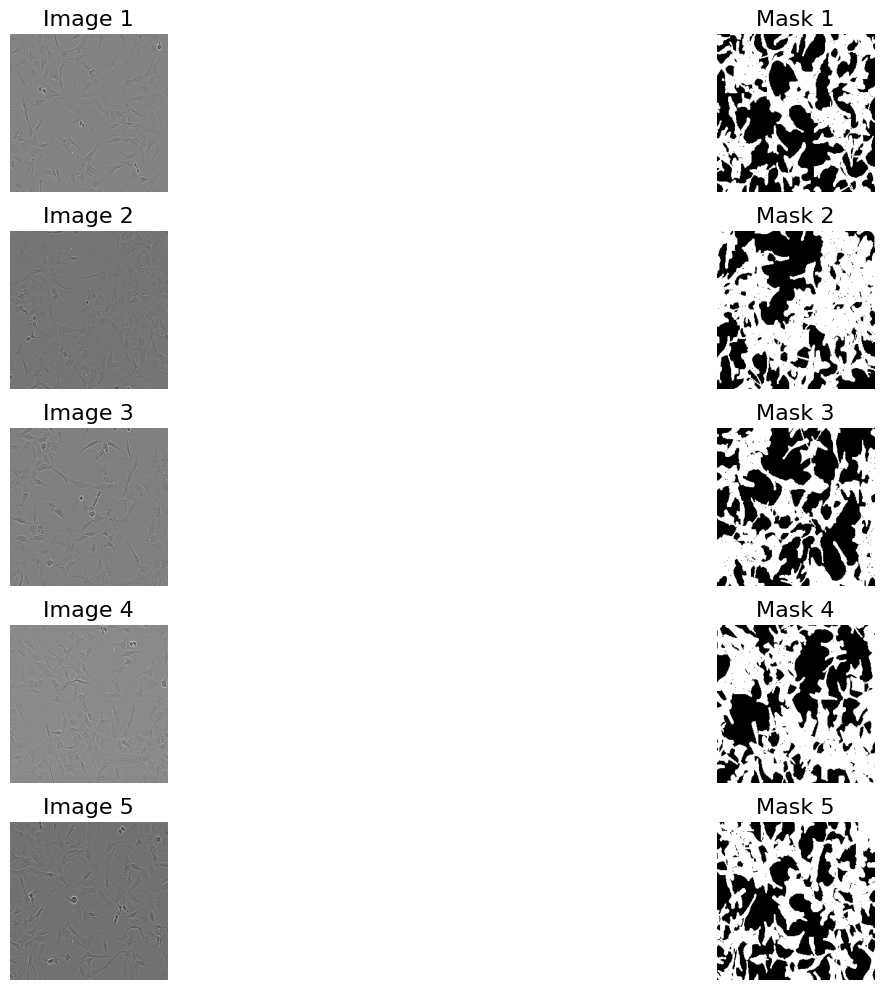

In [ ]:
import matplotlib.pyplot as plt

# Load a batch from the generator
X_train, y_train = next(train_generator)

num_images_to_display = 5


plt.figure(figsize=(20, 10))

for i in range(num_images_to_display):
    # Display the original image
    plt.subplot(num_images_to_display, 2, i * 2 + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i + 1}', fontsize=16)

    # Display the corresponding mask
    plt.subplot(num_images_to_display, 2, i * 2 + 2)
    plt.imshow(y_train[i].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    plt.axis('off')
    plt.title(f'Mask {i + 1}', fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
# Load a batch from the generator
X_train, y_train = next(train_generator)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (16, 256, 256)
Shape of y_train: (16, 256, 256, 1)


# Defining the U-net model and metrics

The selected architecture combines U-Net and watershed techniques, with a custom U-Net designed specifically to address the semantic segmentation task. To transition from semantic to instance segmentation, watershed postprocessing will be applied to the predicted masks, allowing for distinct instance delineation.

Inspired by the LIVECell paper: "A large-scale dataset for label-free live cell segmentation", implemented metrics that provide a comprehensive evaluation of segmentation performance, including mean IoU, Average False Negative Rate (AFNR), and Average Precision (AP). The loss function merges Dice and binary cross-entropy (BCE) losses, leveraging the strengths of both to optimize overlap and pixel-level accuracy. This combination enhances the model's performance in segmenting fine cellular structures while handling class imbalance effectively.


In [4]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
import tensorflow as tf
from keras.losses import binary_crossentropy
from keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

    # IoU Metric for a given threshold
def iou_thresholded(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)  # Cast predictions to float32
    y_true_float = tf.cast(y_true, tf.float32)  # Ensure y_true is also float32

    intersection = tf.reduce_sum(y_true_float * y_pred)  # No need to cast again
    union = tf.reduce_sum(y_true_float + y_pred) - intersection  # Same here

    return (intersection + 1e-7) / (union + 1e-7)


# Mean IoU over thresholds
def mean_iou(y_true, y_pred):
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    iou_scores = [iou_thresholded(y_true, y_pred, threshold) for threshold in thresholds]
    return tf.reduce_mean(iou_scores)

# Average False Negative Rate (AFNR)
def afnr(y_true, y_pred):
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    fn_rates = []
    for threshold in thresholds:
        y_pred_thresh = tf.cast(y_pred > threshold, tf.float32)
        false_negatives = tf.reduce_sum(tf.cast((tf.cast(y_true, tf.float32) == 1) & (y_pred_thresh == 0), tf.float32))
        positives = tf.reduce_sum(tf.cast(y_true == 1, tf.float32))
        fn_rate = false_negatives / (positives + 1e-7)
        fn_rates.append(fn_rate)
    return tf.reduce_mean(fn_rates)

# Average Precision (AP) Metric
def ap_metric(y_true, y_pred):
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    ap_scores = []
    for threshold in thresholds:
        y_pred_thresh = tf.cast(y_pred > threshold, tf.float32)
        true_positives = tf.reduce_sum(tf.cast((tf.cast(y_true, tf.float32) == 1) & (y_pred_thresh == 1), tf.float32))
        false_positives = tf.reduce_sum(tf.cast((tf.cast(y_true, tf.float32) == 0) & (y_pred_thresh == 1), tf.float32))
        positives = tf.reduce_sum(tf.cast(y_true == 1, tf.float32))
        precision = true_positives / (true_positives + false_positives + 1e-7)
        recall = true_positives / (positives + 1e-7)
        ap_score = 2 * (precision * recall) / (precision + recall + 1e-7)
        ap_scores.append(ap_score)
    return tf.reduce_mean(ap_scores)



In [5]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_p_bce, metrics=['accuracy', mean_iou, afnr, ap_metric])
    model.summary()

    return model


# Initialization of [Weights and Biases](https://wandb.ai/site) to track the experiment

To track the experiment’s progress, monitor model performance, and log detailed metrics, Weights & Biases (W&B) was used. W&B integration allows for efficient tracking of various metrics such as loss, accuracy, mean IoU, AFNR, and Average Precision across different epochs, as well as visualization of the model’s predictions. This enables continuous monitoring of model performance and facilitates comparisons between different runs, hyperparameters, and architectures.

In [ ]:
import wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
wandb.init(project="livecell-unet", config=config)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aleksiutenko-evelina (aleksiutenko-evelina-odessa-i-i-mechnikov-national-unive). Use `wandb login --relogin` to force relogin


# Model training

Training U-net for semantic segmentation.

In [11]:
iteration = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Create a directory for saving training process
os.makedirs(f'train_process_{iteration}',  exist_ok=True)
model.compile(optimizer='adam', loss=dice_p_bce, metrics=['accuracy', mean_iou, afnr, ap_metric])
# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=config['steps_per_epoch'],
    epochs=config['epochs'],
    validation_data=val_generator,
    validation_steps=config['validation_steps'],
    verbose=1,
    shuffle=False,
    callbacks=[
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath=f"train_process_{iteration}/my_model_{{epoch:01d}}.keras")
    ]
)


Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3467s 18s/step - accuracy: 0.9219 - afnr: 0.0611 - ap_metric: 0.8862 - loss: -0.8777 - mean_iou: 0.8011 - val_accuracy: 0.9111 - val_afnr: 0.0514 - val_ap_metric: 0.8667 - val_loss: -0.8578 - val_mean_iou: 0.7690
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 115s 583ms/step - accuracy: 0.9236 - afnr: 0.0567 - ap_metric: 0.8891 - loss: -0.8803 - mean_iou: 0.8055 - val_accuracy: 0.9140 - val_afnr: 0.0529 - val_ap_metric: 0.8709 - val_loss: -0.8640 - val_mean_iou: 0.7758
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 108s 548ms/step - accuracy: 0.9247 - afnr: 0.0583 - ap_metric: 0.8897 - loss: -0.8812 - mean_iou: 0.8066 - val_accuracy: 0.9175 - val_afnr: 0.0682 - val_ap_metric: 0.8714 - val_loss: -0.8642 - val_mean_iou: 0.7765
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 107s 547ms/step - accuracy: 0.9266 - afnr: 0.0571 - ap_metric: 0.8931 - loss: -0.8846 - mean_iou: 0.8118 - val_accuracy: 0.9171 - val_afnr: 0.0556 - val_ap_metric: 0.8736 - val_loss: -0.8670 - val_me

Additional metrics(accuracy, afnr) were added to the model. But the main working metric is ap_metric, because afnr does not work (we should fix this in the future).

Accuracy was added for resequencing, but it is not valid for evaluating this shuffle becuase you can have entire background matching but small mitochondrial is not matching.

# Model Evaluation

Loading two models and evaluating with model metrics.

In [7]:
model = simple_unet_model(256, 256,1)
model_path = "/content/drive/MyDrive/LIVEcell_assignment/train_process_7/my_model_9.keras"
model.load_weights(model_path)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
test_generator = data_generator(
    image_directories["test"],    # Directory with test images
    mask_directories["test"],     # Directory with test masks
    batch_size=config['batch_size']
)

# Number of steps in the test dataset
test_steps = len([f for f in os.listdir(image_directories["test"]) if f.endswith('.tif')]) // config['batch_size']

# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)

for metric, result in zip(model.metrics_names, test_results):
    print(f"{metric}: {result}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 348ms/step - accuracy: 0.9263 - afnr: 0.0739 - ap_metric: 0.8886 - loss: -0.8811 - mean_iou: 0.8043
loss: -0.8757458329200745
compile_metrics: 0.9182726144790649


In [ ]:
model_path = "/content/drive/MyDrive/LIVEcell_assignment/train_process_8/my_model_20.keras"
model.load_weights(model_path)

In [ ]:
test_generator = data_generator(
    image_directories["test"],
    mask_directories["test"],
    batch_size=config['batch_size']
)

# Number of steps in the test dataset
test_steps = len([f for f in os.listdir(image_directories["test"]) if f.endswith('.tif')]) // config['batch_size']

# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)

# Output results for each metric
for metric, result in zip(model.metrics_names, test_results):
    print(f"{metric}: {result}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 627s 7s/step - accuracy: 0.9368 - afnr: 0.0721 - ap_metric: 0.9025 - loss: -0.8965 - mean_iou: 0.8260
loss: -0.8918986320495605
compile_metrics: 0.9304515719413757


The difference in the models first one is trained for 9 epochs another one for 29:
1. ap_metric_model_9_epochs: 0.8886
2. ap_metric_model_29_epochs: 0.9025

# Inference on test data

In [ ]:
model.input_shape

(None, 256, 256, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


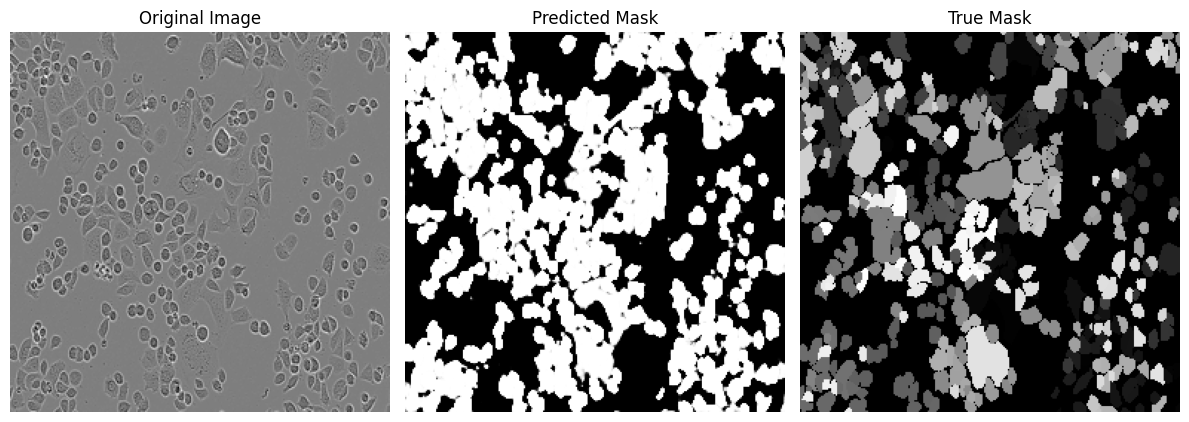

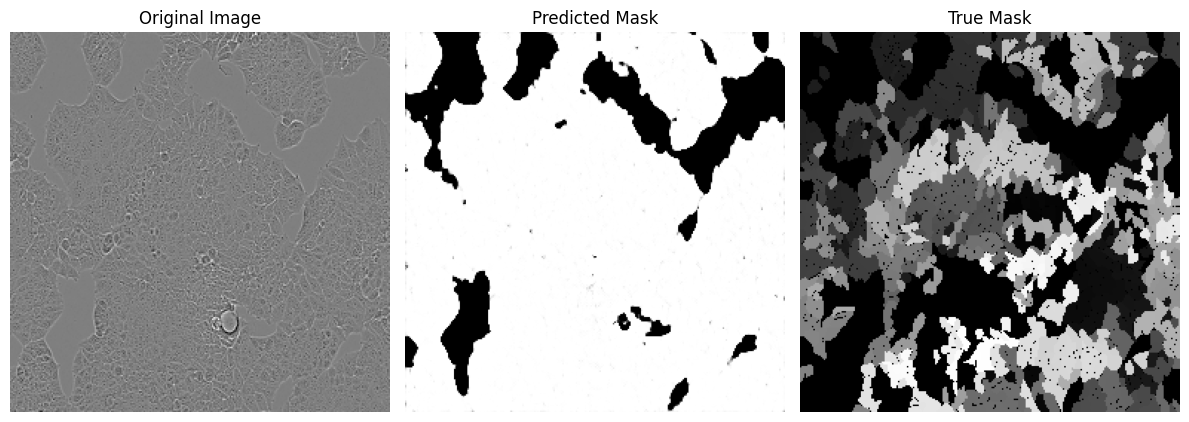

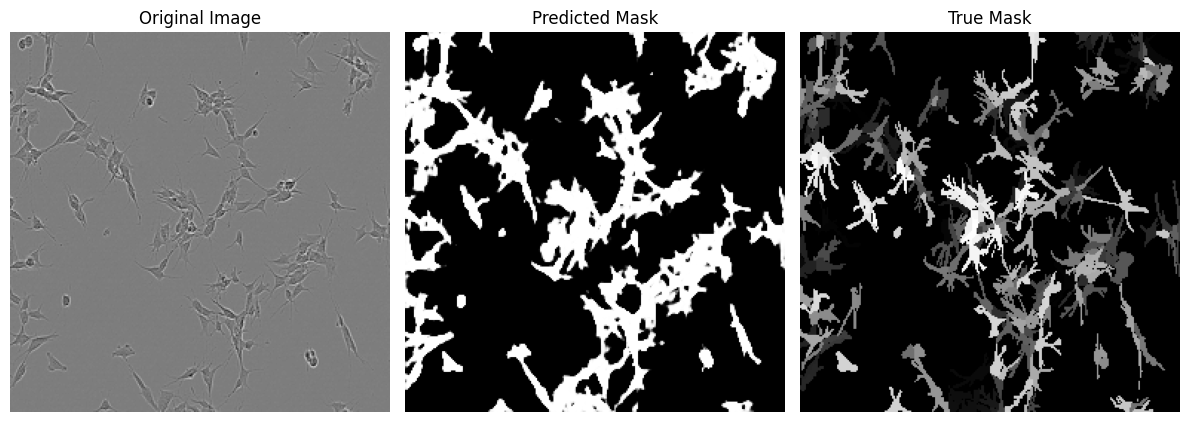

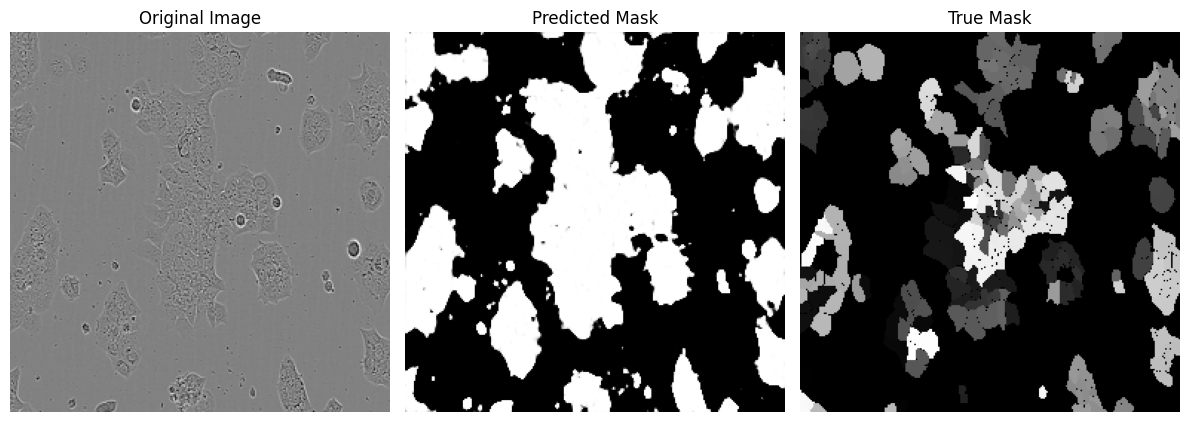

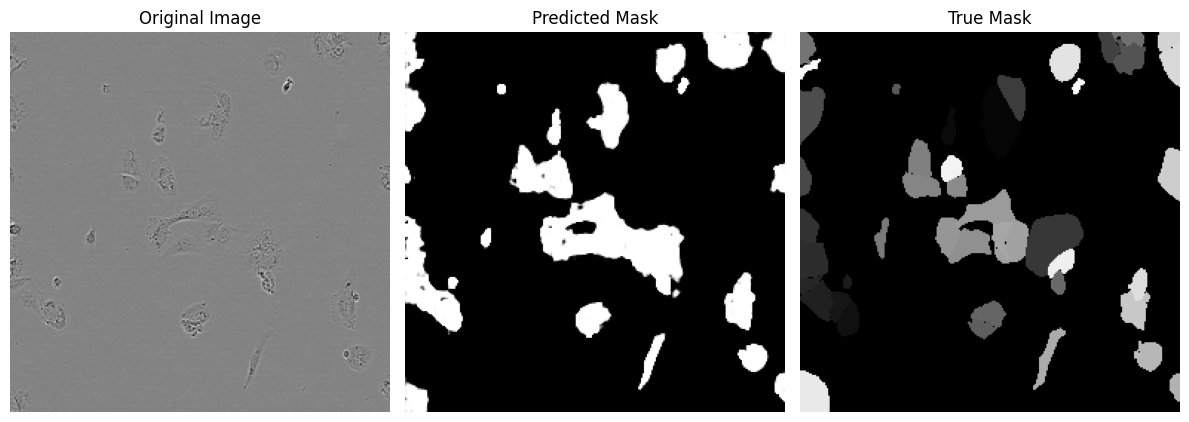

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 


SIZE = 256  # Size to resize images and masks (should be the same as used in training)

# Global mean and standard deviation for normalization
GLOBAL_MEAN = 128.02333355732696
GLOBAL_STD = 7.079153483606509

def normalize_images(image, mean=GLOBAL_MEAN, std=GLOBAL_STD):
    return (image - mean) / std

def load_preprocess_image(image_path, size=SIZE, mean=GLOBAL_MEAN, std=GLOBAL_STD):
    image = Image.open(image_path).resize((size, size))
    image = np.array(image)

    # Normalize the image
    image = normalize_images(image, mean, std)
    return image

def load_and_preprocess_images(image_dir, size=SIZE, num_images=None):
    image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])

    # Limit the number of images if num_images is specified
    if num_images is not None and num_images < len(image_names):
        # Randomly select num_images from the available image names
        image_names = np.random.choice(image_names, num_images, replace=False)

    images = []
    for image_name in image_names:
        image_path = os.path.join(image_dir, image_name)
        image = load_preprocess_image(image_path)
        images.append(image)

    images = np.array(images)
    return images, image_names 

def infer_and_visualize(model, image_dir, mask_dir, num_images=None, size=SIZE):
    # Load and preprocess images
    images, image_names = load_and_preprocess_images(image_dir, size, num_images)

    # Perform inference
    predictions = model.predict(images)

    # Visualize predictions
    for i in range(len(images)):
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 2)
        plt.title('Predicted Mask')
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Load and display the true mask
        true_mask_path = os.path.join(mask_dir, f"{os.path.splitext(image_names[i])[0]}_mask.tif")
        true_mask = Image.open(true_mask_path).resize((size, size))
        true_mask = np.array(true_mask)

        plt.subplot(1, 3, 3)
        plt.title('True Mask')
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


num_images_to_infer = 5

infer_and_visualize(model, image_directories["test"], mask_directories["test"], num_images=num_images_to_infer)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step


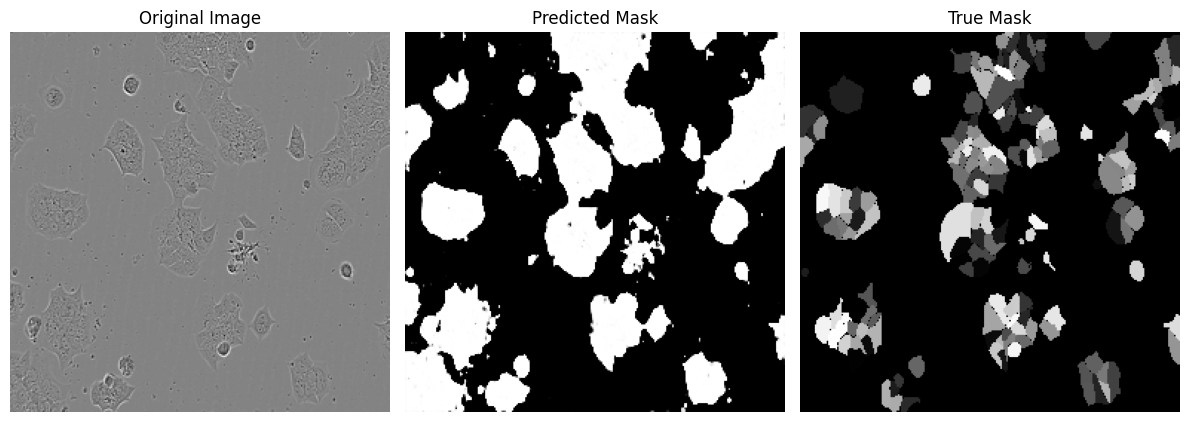

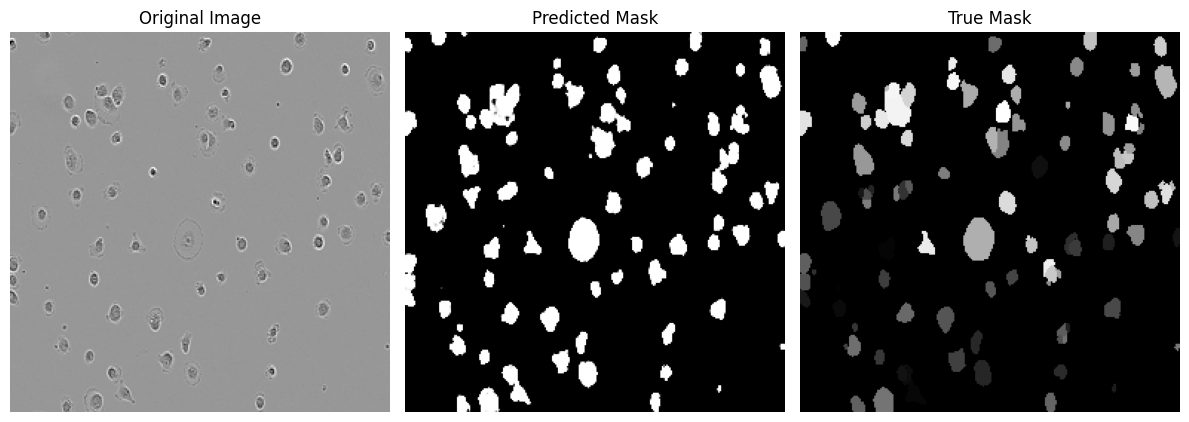

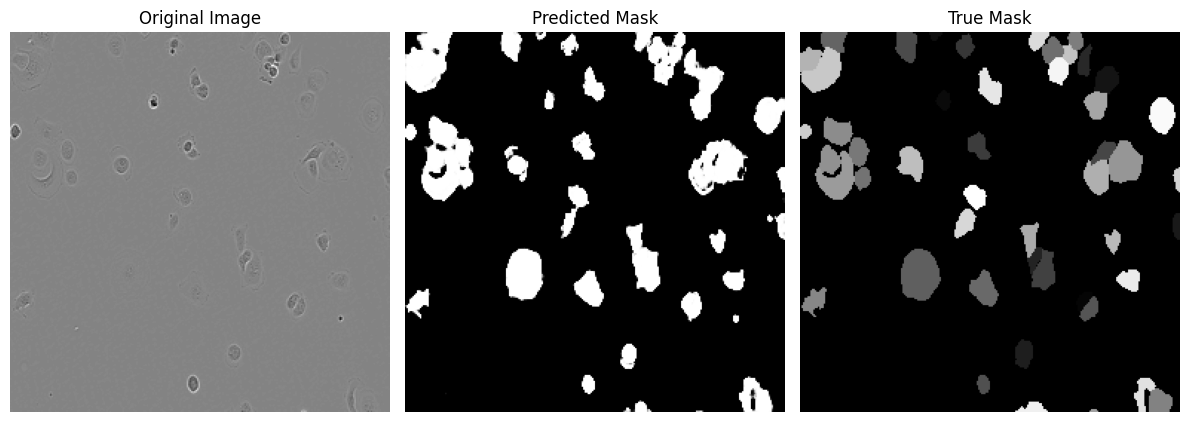

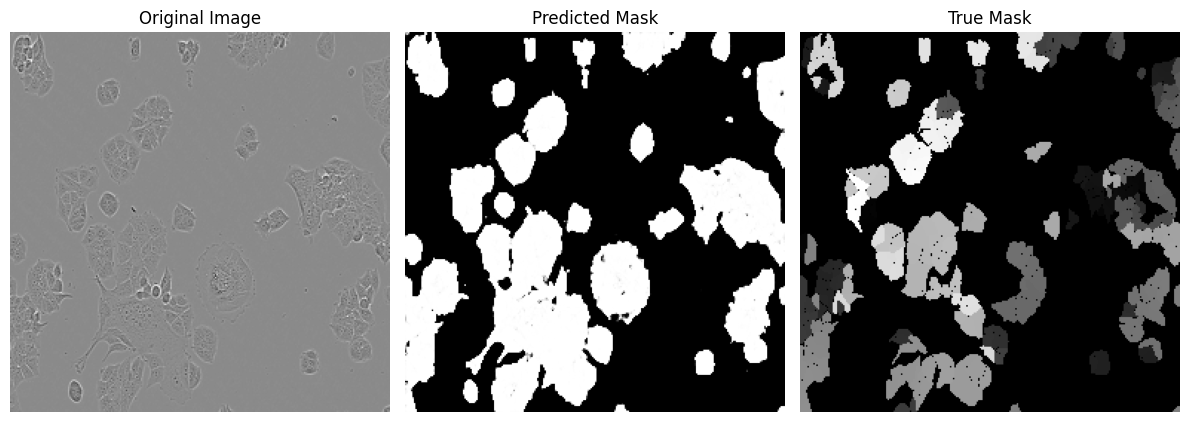

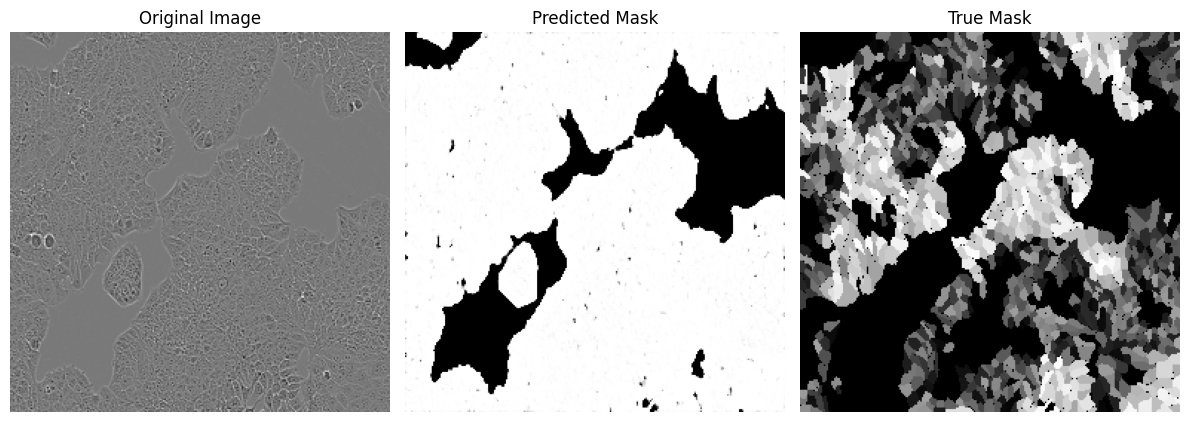

In [ ]:
model_path = "/content/drive/MyDrive/LIVEcell_assignment/train_process_8/my_model_20.keras"
model.load_weights(model_path)
num_images_to_infer = 5
infer_and_visualize(model, image_directories["test"], mask_directories["test"], num_images=num_images_to_infer)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 16)   │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 256, 256, 16)   │              0 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 16)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128, 128, 32)   │              0 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 32)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64, 64, 64)     │              0 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 32, 32, 128)    │              0 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 256, 256, 16)   │            160 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 256, 256, 16)   │              0 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 16)   │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 128, 128, 32)   │              0 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 32)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 64, 64, 64)     │              0 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 64)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 32, 32, 128)    │              0 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 16, 16, 128)    │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


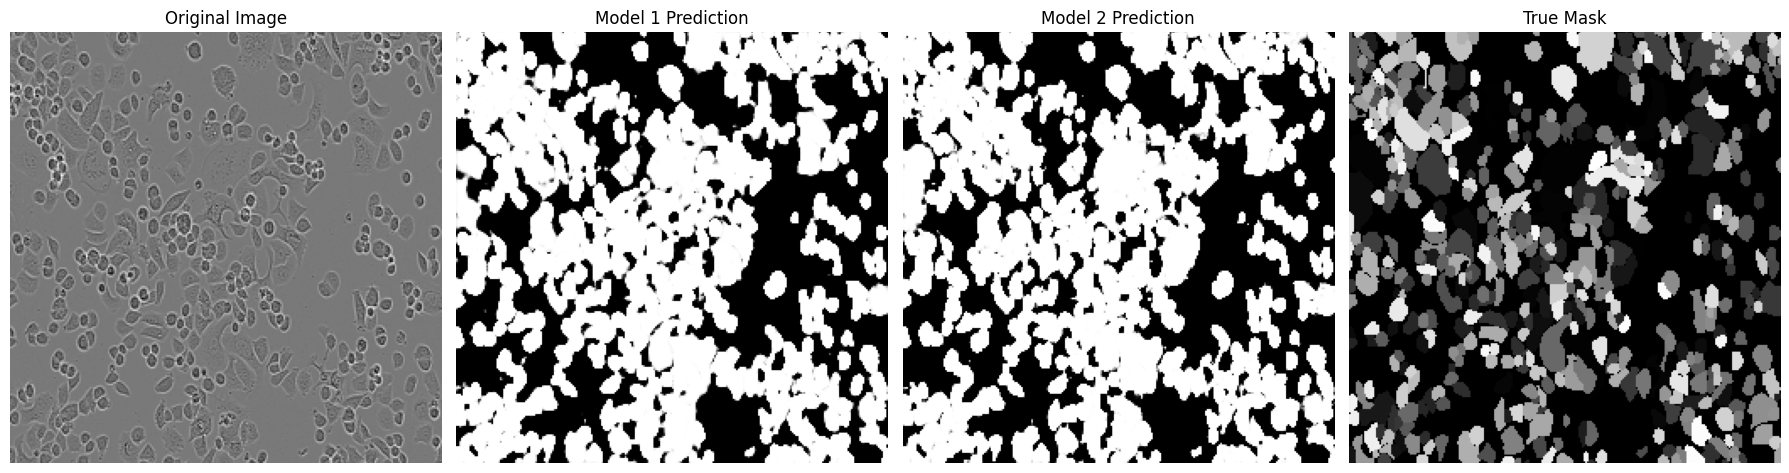

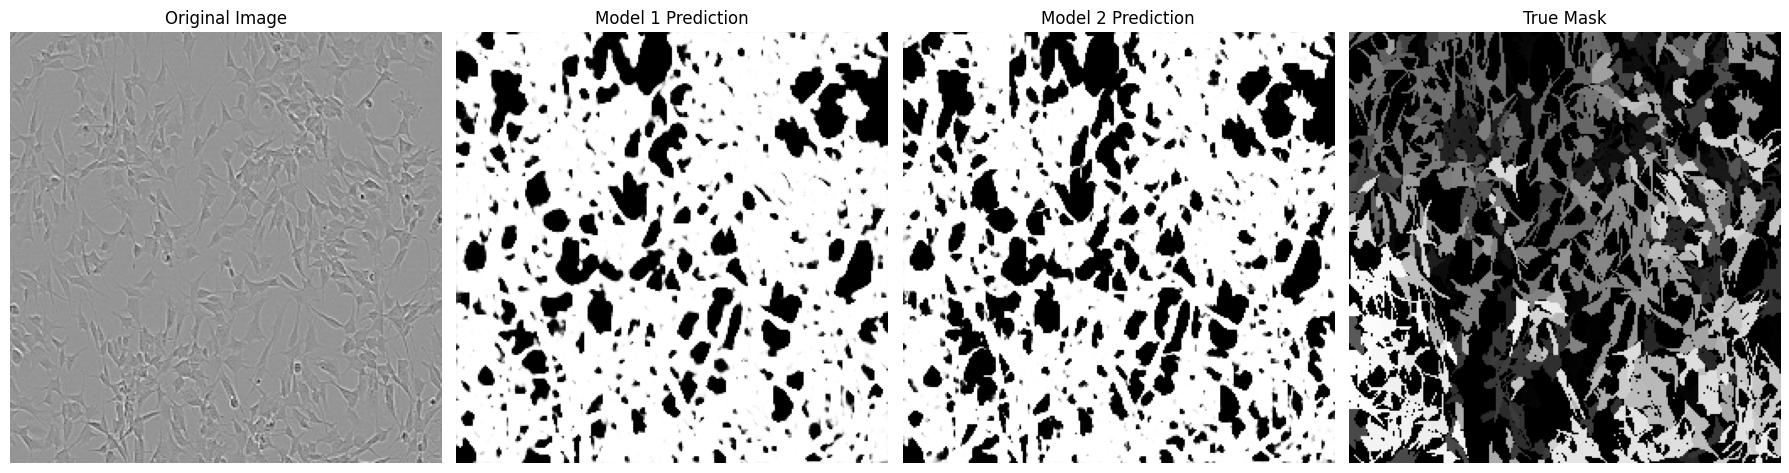

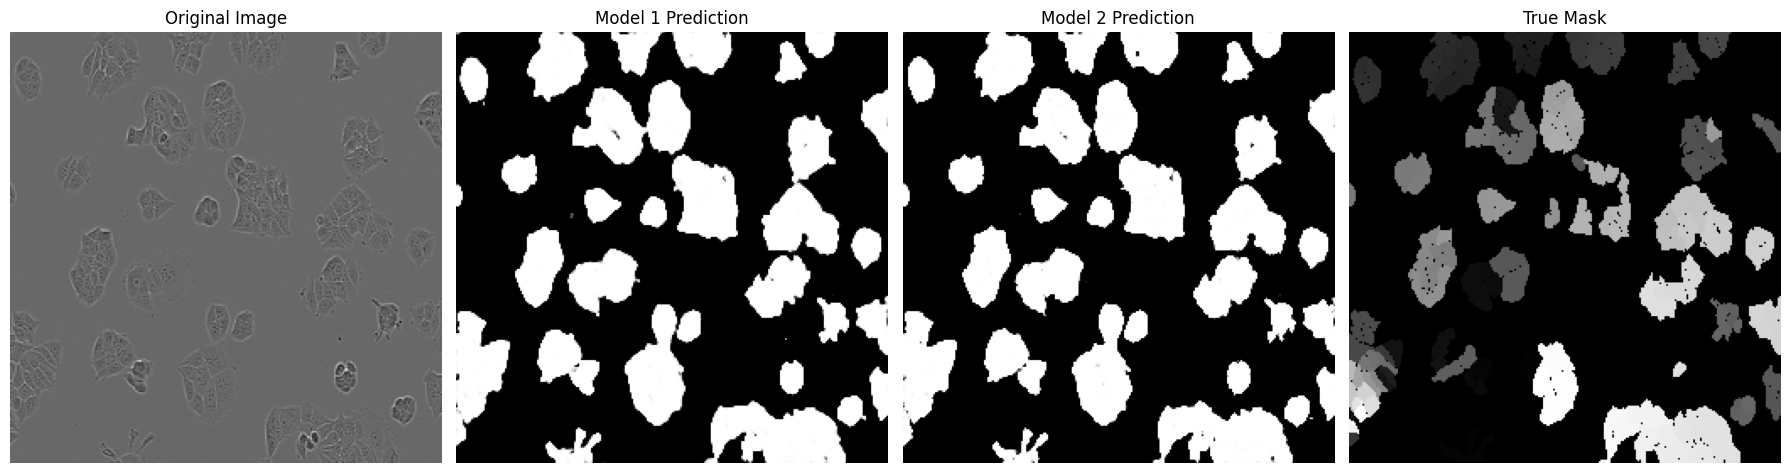

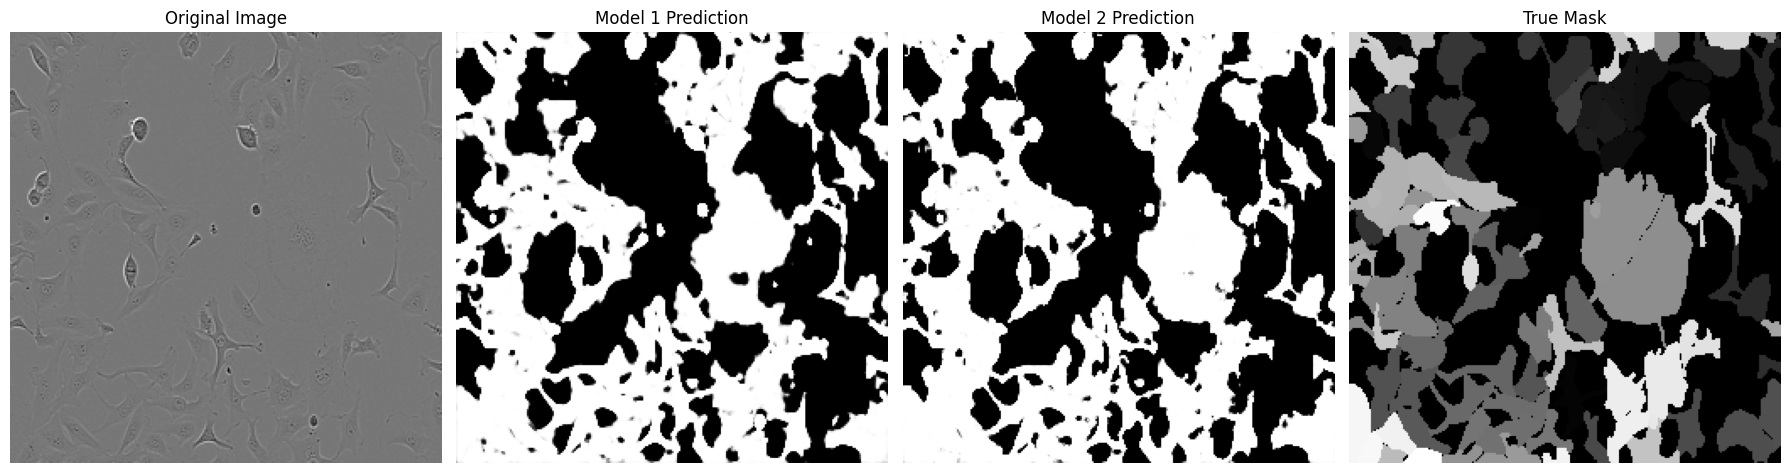

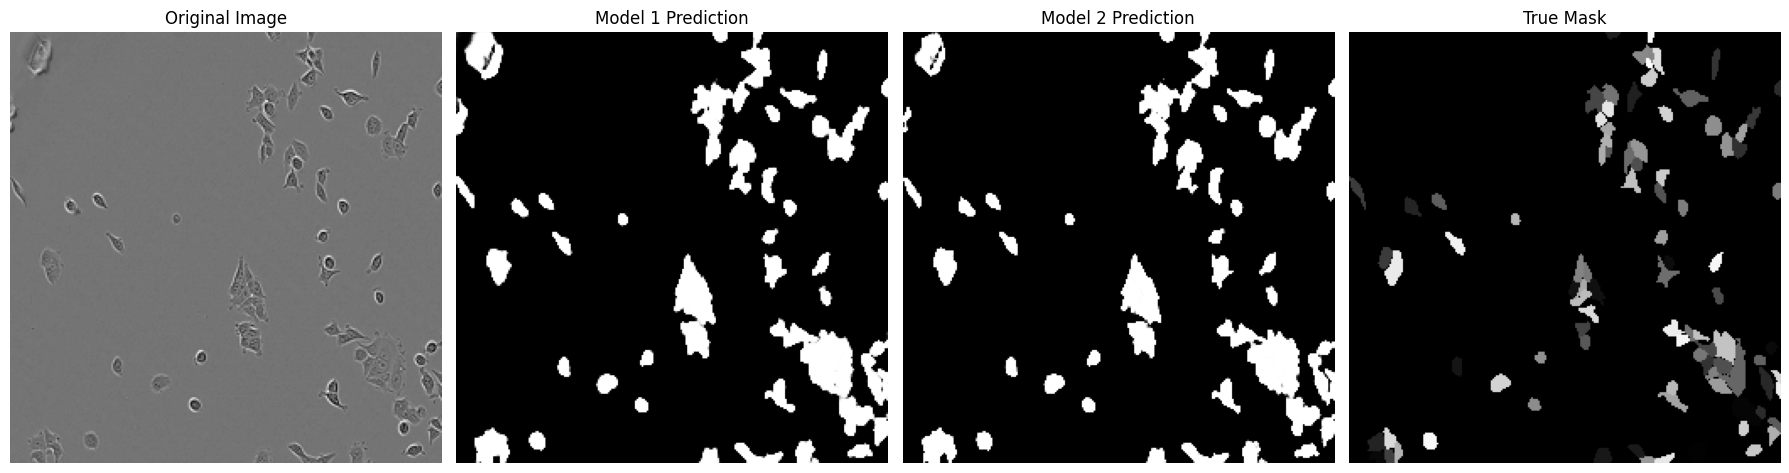

In [ ]:
def load_and_preprocess_images_fixed(image_dir, selected_image_names, size=SIZE):
    images = []
    for image_name in selected_image_names:
        image_path = os.path.join(image_dir, image_name)
        image = load_preprocess_image(image_path)
        images.append(image)

    images = np.array(images)
    return images


def infer_and_visualize_both_models(model1, model2, image_dir, mask_dir, num_images=None, size=SIZE):
    image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])

    if num_images is not None and num_images < len(image_names):
        image_names = np.random.choice(image_names, num_images, replace=False)

    # Load the selected images for both models
    images = load_and_preprocess_images_fixed(image_dir, image_names, size)

    # Perform inference for both models
    predictions1 = model1.predict(images)
    predictions2 = model2.predict(images)

    # Visualize results
    for i, image_name in enumerate(image_names):
        plt.figure(figsize=(18, 6))

        # Original Image
        plt.subplot(1, 4, 1)
        plt.title('Original Image')
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Model 1 Prediction
        plt.subplot(1, 4, 2)
        plt.title('Model 1 Prediction')
        plt.imshow(predictions1[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Model 2 Prediction
        plt.subplot(1, 4, 3)
        plt.title('Model 2 Prediction')
        plt.imshow(predictions2[i].squeeze(), cmap='gray')
        plt.axis('off')

        # True Mask
        true_mask_path = os.path.join(mask_dir, f"{os.path.splitext(image_name)[0]}_mask.tif")
        true_mask = Image.open(true_mask_path).resize((size, size))
        true_mask = np.array(true_mask)

        plt.subplot(1, 4, 4)
        plt.title('True Mask')
        plt.imshow(true_mask, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Load both models
model_path_2 = "/content/drive/MyDrive/LIVEcell_assignment/train_process_8/my_model_20.keras"
model_path_1 = "/content/drive/MyDrive/LIVEcell_assignment/train_process_7/my_model_9.keras"
model1 = get_model()
model2 = get_model()

model1.load_weights(model_path_1)
model2.load_weights(model_path_2)


num_images_to_infer = 5

infer_and_visualize_both_models(model1, model2, image_directories["test"], mask_directories["test"], num_images=num_images_to_infer)


# Postprocessing. Converting semantic segmentations predictions to instance segmentation predictions with watershed.

Class: MCF7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


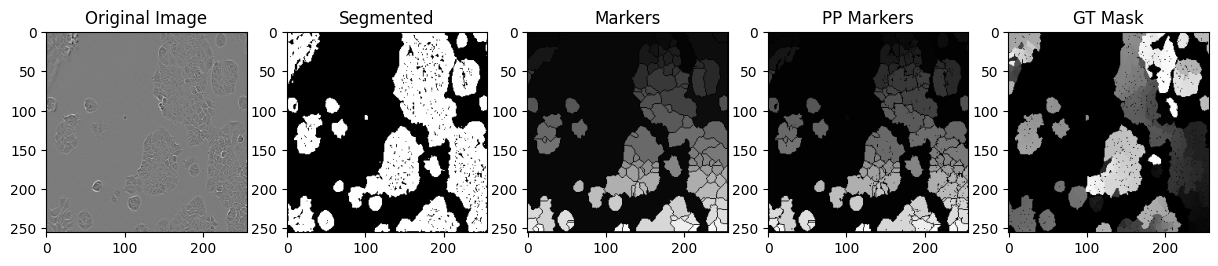

AP 0.006021457375790147
Class: BV2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


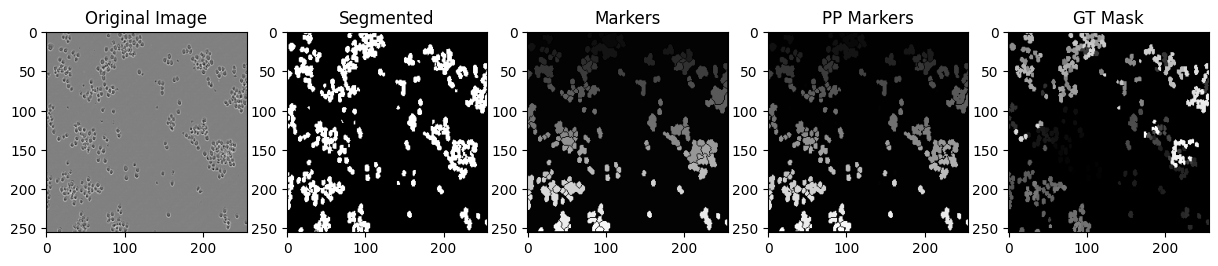

AP 0.16573933531846366
Class: Huh7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


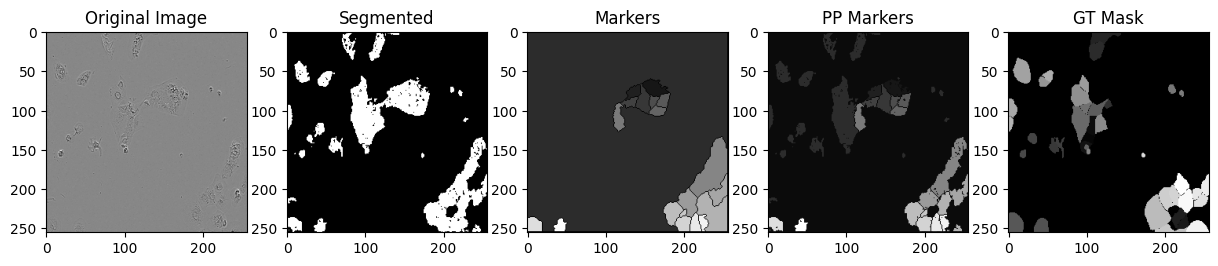

AP 0.054794488159167966
Class: SkBr3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


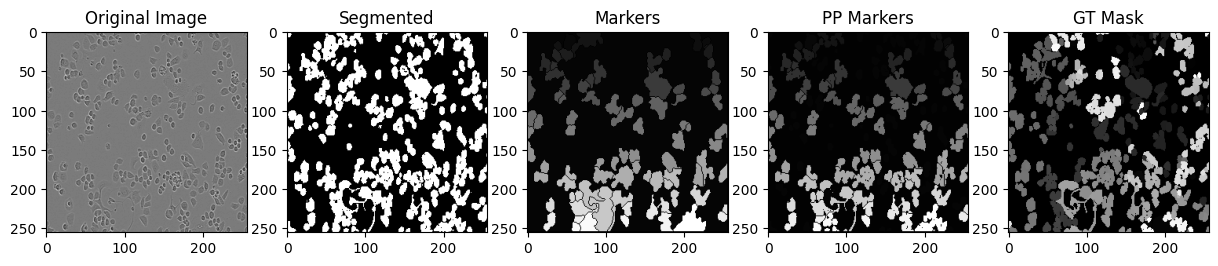

AP 0.11656436867079326
Class: SKOV3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


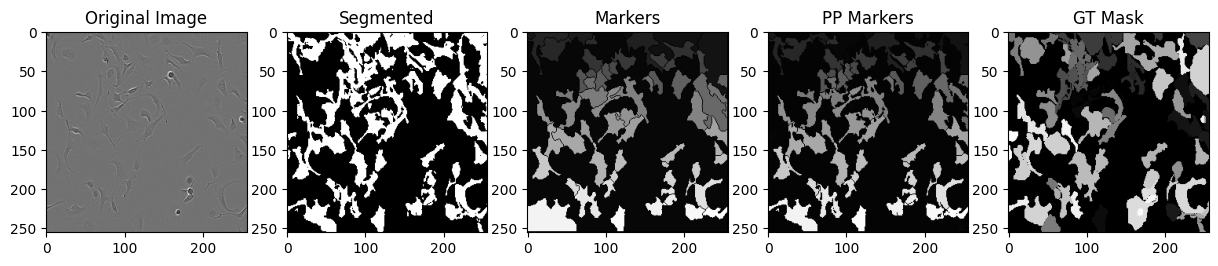

AP 0.08079467471734962
Class: SHSY5Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


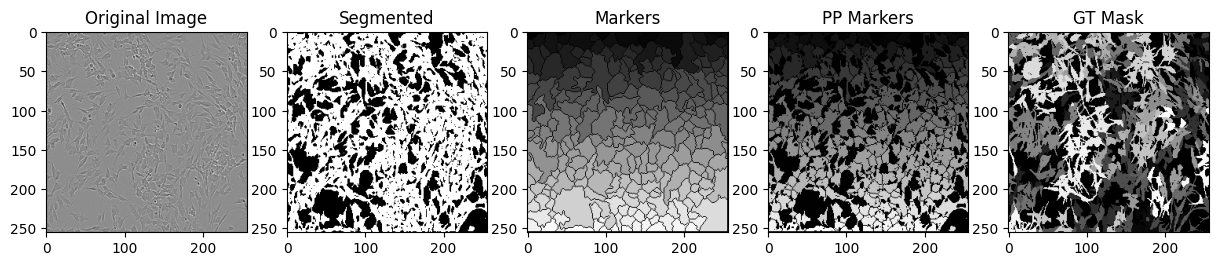

KeyboardInterrupt: 

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from skimage import measure


def postprocess_image(segmented_img):
    # Convert segmented image to binary for watershed
    # ret1, thresh = cv2.threshold(segmented_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # kernel = np.ones((3, 3), np.uint8)
    # opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    # sure_bg = cv2.dilate(opening, kernel, iterations=10)

    # Distance transform to identify sure foreground
    dist_transform = cv2.distanceTransform(segmented_img, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.4* dist_transform.max(), 255, 0)#like erosing
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(segmented_img, sure_fg)

    # Marker labeling for watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers[unknown == 255] = 0
    markers = cv2.watershed(cv2.cvtColor(segmented_img, cv2.COLOR_GRAY2BGR), markers)

    return markers

def get_gt_mask(image_path, size = SIZE):
    mask_dirpath = os.path.join(os.path.dirname(image_path), 'masks')
    gt_mask_path = os.path.join(mask_dirpath, f"{os.path.splitext(os.path.basename(image_path))[0]}_mask.tif")
    gt_mask_image = Image.open(gt_mask_path).resize((size, size))
    gt_mask = np.array(gt_mask_image)
    return gt_mask

def postpr_predict_analyze(image_path, model, treshhold=0.99):
    image_input = load_preprocess_image(image_path)

    predict = model.predict(np.array([image_input]))

    mask_probabilities = predict[0]
    binary_mask = (mask_probabilities > 0.99).astype(np.uint8)

    # Postprocess and analyze segmented image
    markers = postprocess_image(binary_mask)
    properties = measure.regionprops_table(markers, properties=['label', 'area', 'eccentricity', 'solidity'])


    ppr_markers = markers.copy()
    for y in range(ppr_markers.shape[0]):
        for x in range(ppr_markers.shape[1]):
            if binary_mask[y, x] == 0:
                ppr_markers[y, x] = 0

    gt_mask = get_gt_mask(image_path)
    
    image_input = load_preprocess_image(image_path)

    predict = model.predict(np.array([image_input]))

    mask_probabilities = predict[0]
    binary_mask = (mask_probabilities > 0.99).astype(np.uint8)

    # Postprocess and analyze segmented image
    markers = postprocess_image(binary_mask)
    properties = measure.regionprops_table(markers, properties=['label', 'area', 'eccentricity', 'solidity'])


    ppr_markers = markers.copy()
    for y in range(ppr_markers.shape[0]):
        for x in range(ppr_markers.shape[1]):
            if binary_mask[y, x] == 0:
                ppr_markers[y, x] = 0

    gt_mask = get_gt_mask(image_path)

    # Display segmentation and analysis
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 5, 1)
    plt.title('Original Image')
    plt.imshow(image_input, cmap='gray')
    plt.subplot(1, 5, 2)
    plt.title('Segmented')
    plt.imshow(binary_mask, cmap='gray')
    plt.subplot(1, 5, 3)
    plt.title('Markers')
    plt.imshow(markers, cmap='gray')
    plt.subplot(1, 5, 4)
    plt.title('PP Markers')
    plt.imshow(ppr_markers, cmap='gray')
    plt.subplot(1, 5, 5)
    plt.title('GT Mask')
    plt.imshow(gt_mask, cmap='gray')
    plt.show()
    print('AP', ap_metric_instance(ppr_markers, gt_mask))
    return properties



def select_random_image_per_class(directory):
    images_by_class = {}

    for filename in os.listdir(directory):
        if filename.endswith( '.tif'):
            first_word = filename.split('_')[0]

            if first_word not in images_by_class:
                images_by_class[first_word] = []
            images_by_class[first_word].append(os.path.join(directory, filename))

    random_images = {class_name: random.choice(images) for class_name, images in images_by_class.items()}

    return random_images


directory = image_directories['test']
random_images = select_random_image_per_class(directory)

for class_name, image_path in random_images.items():
    print(f"Class: {class_name}")
    props = postpr_predict_analyze(image_path, model)
    df = pd.DataFrame(props)

The combination of U-net and watershed is not working well(markers image). Especially for occluded objects(as some classes of cells).
As a small improvement background needs to be substaracted.

In [ ]:
def get_postpr_predict(image_path, model, treshhold=0.99):
    # Load and preprocess image
    image_input = load_preprocess_image(image_path)

    predict = model.predict(np.array([image_input]))

    mask_probabilities = predict[0]
    binary_mask = (mask_probabilities > 0.99).astype(np.uint8)

    # Postprocess and analyze segmented image
    markers = postprocess_image(binary_mask)
    properties = measure.regionprops_table(markers, properties=['label', 'area', 'eccentricity', 'solidity'])


    ppr_markers = markers.copy()
    for y in range(ppr_markers.shape[0]):
        for x in range(ppr_markers.shape[1]):
            if binary_mask[y, x] == 0:
                ppr_markers[y, x] = 0
    return ppr_markers

TODO: make a background adding not as postprocess of markers but do not incude it in watershed(sure_backg). But it seems that in this case watershed is not appropriate.

# Evaluating postprocessed predictions as instance segmentation.

In [231]:
def evaluate_ap_by_class_instance(directory, model):
    test_dataset = load_test_dataset(directory)
    ap_results = {}

    for class_name, image_paths in test_dataset.items():
        class_aps = []

        for image_path in image_paths:
            ppr_predict = get_postpr_predict(image_path, model)
            gt_mask = get_gt_mask(image_path)
            ap_score = ap_metric_instance(gt_mask, ppr_predict)
            class_aps.append(ap_score)

        # Average AP across images for the current class
        ap_results[class_name] = np.mean(class_aps)

    return ap_results

In [234]:
from skimage import measure

def calculate_iou(mask1, mask2):
    # Calculate the intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    # Handle division by zero
    iou = intersection / (union + 1e-7)

    return iou
def separate_instances(mask):
    return measure.label(mask, connectivity=1)

def ap_metric_instance(y_true, y_pred):
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    ap_scores = []

    for threshold in thresholds:
        y_true_labeled = measure.label(y_true)
        y_pred_labeled = measure.label(y_pred)

        tp, fp, fn = 0, 0, y_true_labeled.max()

        for pred_label in range(1, y_pred_labeled.max() + 1):
            pred_instance = y_pred_labeled == pred_label
            max_iou, matched_gt_label = 0, None

            for gt_label in range(1, y_true_labeled.max() + 1):
                gt_instance = y_true_labeled == gt_label
                iou = calculate_iou(pred_instance, gt_instance)

                if iou > max_iou:
                    max_iou = iou
                    matched_gt_label = gt_label

            if max_iou >= threshold:
                tp += 1
                fn -= 1  # Decrement FN since the GT instance is matched
            else:
                fp += 1

        precision = tp / (tp + fp + 1e-7)
        recall = tp / (tp + fn + 1e-7)
        ap_score = 2 * (precision * recall) / (precision + recall + 1e-7)
        ap_scores.append(ap_score)

    return np.mean(ap_scores)

In [ ]:
import os
from collections import defaultdict

def load_test_dataset(directory):
    test_dataset = defaultdict(list)

    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            class_name = filename.split('_')[0]
            file_path = os.path.join(directory, filename)
            test_dataset[class_name].append(file_path)

    return test_dataset



test_directory = image_directories['test']

ap_results = evaluate_ap_by_class_instance(test_directory, model)

for class_name, ap in ap_results.items():
    print(f"{class_name}: {ap * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 